In [2]:
import re, os
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pprint import pprint

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.weight': 'bold'})

hatches = ['o', '*', '\\\\', 'O', 'x', '\\', '--', 'o']
markers = ['o', '^', "*"]
linestyles = ['dashdot', 'solid', '--']
orig_colors = sns.color_palette("pastel")
orig_colors1 = sns.color_palette("colorblind")

recmp_swap_colors = [
    orig_colors[0],
    orig_colors[2],
    orig_colors1[2],
]

seq_colors = [
    orig_colors[1],
    orig_colors[3],
    orig_colors[6], 
]

base_plots_path="./plots"
os.makedirs(base_plots_path, exist_ok=True)

[0 1 2 3 4]


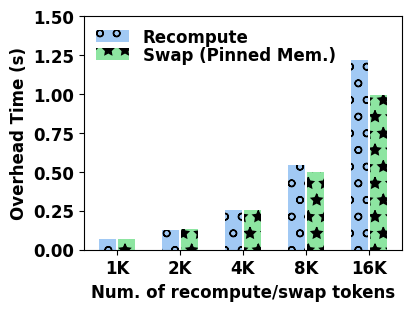

In [3]:
##################Plot Sequence Length Impact##################
def plot_q4a_evicted_tokens():
    # output_file = f"./plots_ipdps/evicted_len_on_overhead"
    output_file = f"{base_plots_path}/evicted_len_on_overhead" 
    x_labels = ("1K", "2K", "4K", "8K", "16K")
    overhead_time = {
        "Recompute": [0.06754, 0.128356, 0.257509, 0.543983333, 1.2168],
        "Swap (Pinned Mem.)": [0.069011333, 0.129981, 0.253229667, 0.500125667, 0.993507667],
    }
     
    # plot the graph
    bar_labels = list(overhead_time.keys())
    bar_width = 0.3
    bar_gap = -0.02
    xrange = np.arange(len(x_labels))
    print(xrange)
    
    fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)
    offset = -0.5
    for i, label in enumerate(bar_labels):
        ax.bar(xrange + offset * bar_width, overhead_time[label], bar_width+bar_gap, label=label, color=recmp_swap_colors[i],  hatch=hatches[i])
        offset += 1
 
    ax.set_xlabel('Num. of recompute/swap tokens', fontsize=12, fontweight='bold')
    ax.set_ylabel('Overhead Time (s)', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    ax.set_ylim(top=1.5)
    ax.set_xticklabels(x_labels)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, bar_labels, ncol=1, frameon=False, fontsize=12, loc='upper left',
             borderpad=0.2, labelspacing=0., columnspacing=0.2, ) 
    
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    
    plt.show()


plot_q4a_evicted_tokens()

[0 1 2 3 4 5]


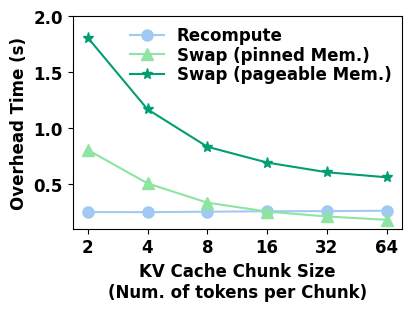

In [4]:
##################Plot Block Size Impact##################
def plot_q4c_overhead(is_nameX_blockSize, save_file_name):
    x_labels = ("2", "4", "8", "16", "32", "64") 

    overhead_time = {
        "Recompute": [0.249826333, 0.249349667, 0.253189667, 0.257226667, 0.258577, 0.261759],
        "Swap (pinned Mem.)": [0.806272, 0.506584, 0.334184, 0.254355, 0.210494333, 0.180777],
        "Swap (pageable Mem.)": [1.809973, 1.16873, 0.833906333, 0.692599667, 0.605930667, 0.560972333],
    }
    
    # plot the graph
    bar_labels = list(overhead_time.keys())
    xrange = np.arange(len(x_labels))
    print(xrange)
    
    fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)
    offset = -0.5
    for i, label in enumerate(bar_labels):
        ax.plot(xrange, overhead_time[label], color=recmp_swap_colors[i], marker=markers[i], linestyle='solid',
                 markersize=8, markerfacecolor=recmp_swap_colors[i], markeredgecolor=recmp_swap_colors[i], zorder=1)
        offset += 1

    if is_nameX_blockSize:
        ax.set_xlabel('KV Cache Block Size\n(Num. of tokens per Block)', fontsize=12, fontweight='bold')
    else:
        ax.set_xlabel('KV Cache Chunk Size\n(Num. of tokens per Chunk)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Overhead Time (s)', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    ax.set_ylim(top=2)
    ax.set_xticklabels(x_labels)

    ax.legend(bar_labels, ncol=1, frameon=False, fontsize=12, loc='upper right',
             borderpad=0.1, labelspacing=0.1, columnspacing=0.2, )

    plt.savefig(f"{save_file_name}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{save_file_name}.png", format='png', bbox_inches='tight')
    
    plt.show()

output_file = f"{base_plots_path}/block_size_on_overhead"
plot_q4c_overhead(False, f"{output_file}_chunk")

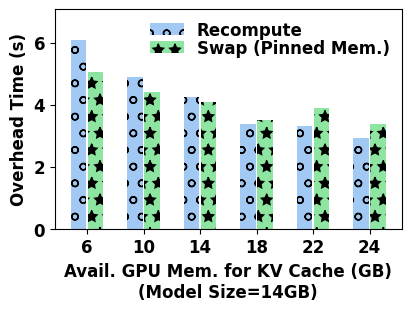

In [5]:
#######Plot GPU utilization. for KV cache Impact##################
#######Plot Available GPU Size for KV cache Impact##################
def plot_q4e_gpu(dataset):
    # setup: context-length=8K, prompt>=1500, output>=1024 (using SharedGPT dataset)
    output_file = f"{base_plots_path}/GPU_on_overhead"
    # x_labels = ("50%", "60%", "70%", "80%", "90%", "95%")
    x_labels = dataset['Aail. GPU Mem']
    overhead_time = dataset['overhead_time']

    # plot the graph
    bar_labels = list(overhead_time.keys())
    bar_width = 0.3
    bar_gap = -0.02
    xrange = np.arange(len(x_labels))
    
    fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)
    offset = -0.5
    for i, label in enumerate(bar_labels):
        ax.bar(xrange + offset * bar_width, overhead_time[label], bar_width+bar_gap, label=label, color=recmp_swap_colors[i],  hatch=hatches[i])
        offset += 1

    # # Annotate the bars
    # for j, glabel in enumerate(x_labels):
    #     offset = -0.5
    #     for i, blabel in enumerate(bar_labels):
    #         value = overhead_time[blabel][j]
    #         # print(value)
    #         ax.annotate(f'{value:.2f}', (xrange[j] + offset * bar_width, value + 0.2),
    #                     ha='center', va='bottom', rotation=90, fontsize=10, fontweight='normal')
    #         offset += 1
    
    ax.set_xlabel('Avail. GPU Mem. for KV Cache (GB)\n(Model Size=14GB)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Overhead Time (s)', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    ax.set_ylim(top=max(max(overhead_time["Recompute"]), max(overhead_time["Swap (Pinned Mem.)"])) + 1)
    ax.set_xticklabels(x_labels)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, bar_labels, ncol=1, frameon=False, fontsize=12, loc='upper right',
             borderpad=0.2, labelspacing=0., columnspacing=0.2, ) 
    
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    
    plt.show()

# Yarn-llama-2-7B model with 8K context length. 
results_sharedgpt = {
    'Aail. GPU Mem': ["6", "10", "14", "18", "22", "24"],
    'overhead_time': {
        "Recompute": [3.130781, 2.997822, 1.81973, 2.195845, 1.355049, 1.261872],
        "Swap (Pinned Mem.)": [2.280529, 2.11094, 1.728998, 1.864579, 1.358579, 1.14482],
    }  
}

# Yarn-llama-2-7B model with 8K context length.
results_zipf = {
    'Aail. GPU Mem': ["6", "10", "14", "18", "22", "24"],
    'overhead_time': {
        "Recompute": [6.068605, 4.900238, 4.25184, 3.363923, 3.303157, 2.920503],
        "Swap (Pinned Mem.)": [5.040942, 4.421982, 4.094429, 3.518624, 3.900957, 3.372103],
    }   
}

plot_q4e_gpu(results_zipf)

[0 1 2]


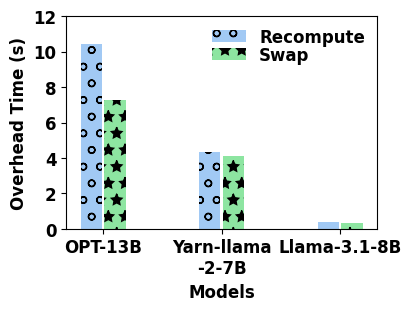

In [6]:
#######Plot Models Impact##################
def plot_q4f_models_on_overhead(dataset):
    # requests=64, prompt=512, output=1024
    output_file = f"{base_plots_path}/diff_models_on_overhead"
    x_labels = dataset['Models']
    overhead_time = dataset['overhead_time']
    
    # plot the graph
    bar_labels = list(overhead_time.keys())
    bar_width = 0.2
    bar_gap = -0.02
    xrange = np.arange(len(x_labels))
    print(xrange)
    
    fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)
    offset = -0.5
    for i, label in enumerate(bar_labels):
        ax.bar(xrange + offset * bar_width, overhead_time[label], bar_width+bar_gap, label=label, color=recmp_swap_colors[i],  hatch=hatches[i])
        offset += 1

    # # Annotate the bars
    # for j, glabel in enumerate(x_labels):
    #     offset = -0.5
    #     for i, blabel in enumerate(bar_labels):
    #         value = overhead_time[blabel][j]
    #         # print(value)
    #         ax.annotate(f'{value:.2f}', (xrange[j] + offset * bar_width, value + 0.2),
    #                     ha='center', va='bottom', rotation=90, fontsize=10, fontweight='normal')
    #         offset += 1

    ax.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax.set_ylabel('Overhead Time (s)', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    ax.set_ylim(top=12)
    ax.set_xticklabels(x_labels, fontsize=12, rotation=0)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, bar_labels, ncol=1, frameon=False, fontsize=12, loc='upper right',
             borderpad=0.2, labelspacing=0., columnspacing=0.2, ) 
    
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    
    plt.show()

# context-length are 2K, 4K, 64K respectively.
# sequence_length (in/output): 512/1024, requests=64
dataset_fixedlen = {
    'Models': ["OPT-13B", "Yarn-llama-2-7B", "Llama-3.1-8B"],
    'overhead_time': {
        "Recompute": [8.583552, 3.705266, 0.919386],
        "Swap": [5.733416, 3.234068, 0.42001],
    }
}

# context-length are 2K, 8K, 64K respectively.
# zipf: min=512, max=2048, requests=128
dataset_varlen = {
    'Models': ["OPT-13B", "Yarn-llama\n-2-7B", "Llama-3.1-8B"],
    'overhead_time': {
        "Recompute": [10.44145, 4.357703, 0.386808],
        "Swap": [7.268782, 4.141683, 0.34239],
    }
}

dataset_varlen_1 = {
    'Models': ["OPT-13B", "Yarn-llama\n-2-7B", "Llama-3.1-8B"],
    'overhead_time': {
        "Recompute": [10.44145, 4.73796, 0.249564],
        "Swap": [7.268782, 4.408232, 0.196849],
    }
}

plot_q4f_models_on_overhead(dataset_varlen)

xrang= [0. 1. 2.]
xrang= [0. 1. 2.]
xrang= [3.5 4.5 5.5]
xrang= [3.5 4.5 5.5]
xrang= [7. 8. 9.]
xrang= [7. 8. 9.]
xrang= [10.5 11.5 12.5]
xrang= [10.5 11.5 12.5]
xrang= [14.8 15.8 16.8]
xrang= [14.8 15.8 16.8]
xrang= [20 21 22]
xrang= [20 21 22]


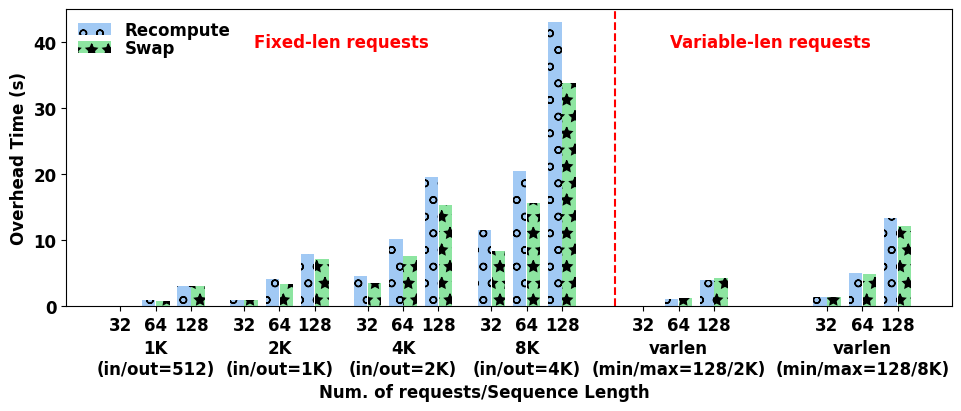

In [7]:
# Plot the impact of batch size
def plot_Q4b_batch_size(dataset):
    output_file = f"{base_plots_path}/seqlen_and_requests_on_overhead"

    # create the x-axis range and labels 
    xrange_of_each_group = []
    groups_len = len(dataset['overhead_time'].keys()) 
    prelen, group_width = 0, 0.5
    for i in range(groups_len):
        if i == 4:
            group_width = 0.7
        if i == 5:
            group_width = 1
        xrange_of_each_group.append(np.arange(len(dataset['requests'])) + (prelen + i * group_width))
        prelen += len(dataset['requests'])
    x_labels = dataset['requests'] * groups_len
    flattened_xrange = np.concatenate(xrange_of_each_group)

    # Plotting the data
    fig, ax = plt.subplots(figsize=(9.5, 4), constrained_layout=True)

    for i, tst_case_label in enumerate(dataset['overhead_time'].keys()):
        xrange = xrange_of_each_group[i]
        # plot recompute and swap
        bar_width = 0.4
        offset = -0.5
        bar_gap = -0.02
        for j, cat_label in enumerate(dataset['overhead_time'][tst_case_label].keys()):
            print("xrang=", xrange)
            if i == 0:
                ax.bar(xrange + offset * bar_width, dataset['overhead_time'][tst_case_label][cat_label], bar_width + bar_gap, label=cat_label, hatch=hatches[j], color=recmp_swap_colors[j])
            else:
                ax.bar(xrange + offset * bar_width, dataset['overhead_time'][tst_case_label][cat_label], bar_width + bar_gap, label='_nolegend_', hatch=hatches[j], color=recmp_swap_colors[j])
            offset += 1
        offset = len(xrange)
    
    ax.set_ylim(top=45)

    ax.set_xticks(flattened_xrange)
    ax.set_xticklabels(x_labels, fontsize=12)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, ncol=1, frameon=False, fontsize=12, loc='upper left',
             borderpad=0.2, labelspacing=0., columnspacing=0.2, ) 

    # Custom X-axis labels
    def add_custom_labels(pos, label):
        ax.text(pos, -8, label, ha='center', va='center', fontsize=12)

    # # Adding custom labels below the x-axis
    tst_case= list(dataset['overhead_time'].keys())
    for i in range(groups_len):
        add_custom_labels(np.mean(xrange_of_each_group[i]), tst_case[i])

    # Add the x_label and y_label
    # pos = np.mean(x_small) + (np.mean(x_large) - np.mean(x_small)) / 2
    pos = np.mean(flattened_xrange)
    ax.text(pos, -13, "Num. of requests/Sequence Length", ha='center', va='center', fontsize=12)
    ax.set_ylabel('Overhead Time (s)', fontsize=12, fontweight='bold')

    pos_1, pos_2= np.mean(flattened_xrange[0:12]), np.mean(flattened_xrange[12:])
    ax.text(pos_1, 40, "Fixed-len requests", ha='center', va='center', color='r', fontsize=12)
    ax.text(pos_2, 40, "Variable-len requests", ha='center', va='center', color='r', fontsize=12)

    plt.axvline(x=xrange_of_each_group[3][-1] + 1.5, color='r', linestyle='--', label='Vertical Line')

    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()

# sequence_length together with number of requests
dataset_fixedlen_varlen = {
    'requests': [32, 64, 128],
    'overhead_time': {
        '1K\n(in/out=512)': {'Recompute': [0, 0.936219, 3.099949], 'Swap': [0, 0.867123, 3.057151]},
        '2K\n(in/out=1K)': {'Recompute': [1.017948, 4.054129, 7.969399], 'Swap': [0.987282, 3.329039, 7.218396]},
        '4K\n(in/out=2K)': {'Recompute': [4.581931, 10.169337, 19.536783], 'Swap': [3.556812, 7.675467, 15.356339]},
        '8K\n(in/out=4K)': {'Recompute': [11.524275, 20.437773, 43.097949], 'Swap': [8.314116, 15.713491, 33.842197]},
        'varlen\n(min/max=128/2K)': {'Recompute': [0, 1.040041, 4.035722], 'Swap': [0, 1.248764, 4.313512]},
        'varlen\n(min/max=128/8K)': {'Recompute': [1.376348, 5.016567, 13.341441], 'Swap': [1.430605, 4.819552, 12.087833]},
    }
}

plot_Q4b_batch_size(dataset_fixedlen_varlen)
